In [1]:
# import libraries

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LassoLarsCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np

import math
import time

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

sns.set()

# I want crisp graphics, so we'll output SVG
#%config InlineBackend.figure_format = 'svg'

In [2]:
# Load data
df_cleaned = pd.read_csv('data/listings_cleaned.csv', low_memory=False)
df_cleaned.head()

id  price  latitude  longitude property_type        room_type  \
0  2265  225.0  30.27750  -97.71398         House  Entire home/apt   
1  5245  100.0  30.27577  -97.71379         House     Private room   
2  5456   95.0  30.26112  -97.73448    Guesthouse  Entire home/apt   
3  5769   40.0  30.45697  -97.78422         House     Private room   
4  6413   99.0  30.24829  -97.73726    Guesthouse  Entire home/apt   

   accommodates  bathrooms  bedrooms  bed_type  ... is_business_travel_ready  \
0             4        2.0       2.0  Real Bed  ...                        f   
1             2        1.0       1.0  Real Bed  ...                        f   
2             3        1.0       1.0  Real Bed  ...                        f   
3             2        1.0       1.0  Real Bed  ...                        f   
4             2        1.0       1.0  Real Bed  ...                        f   

           cancellation_policy  host_is_superhost  \
0  strict_14_with_grace_period                  t   
1  strict_14_with_grace_period                  t   
2  strict_14_with_grace_period                  t   
3                     moderate                  t   
4  strict_14_with_grace_period                  t   

                         listing_url  cleaning_fee security_deposit  \
0  https://www.airbnb.com/rooms/2265         100.0            500.0   
1  https://www.airbnb.com/rooms/5245          75.0            500.0   
2  https://www.airbnb.com/rooms/5456           0.0            100.0   
3  https://www.airbnb.com/rooms/5769           0.0              0.0   
4  https://www.airbnb.com/rooms/6413          50.0              0.0   

  extra_people guests_included region price_per_person  
0         30.0               4   East        56.250000  
1         35.0               2   East        50.000000  
2         45.0               2   East        31.666667  
3          0.0               2  North        20.000000  
4         25.0               2  South        49.500000  

[5 rows x 26 columns]

In [3]:
# Create a list to include the names of columns we want to use
features_list = [
    'property_type',
    'room_type',
    'bathrooms',
    'bedrooms',
    'host_is_superhost',
    'region',
    'accommodates',
    'review_scores_rating',
    'number_of_reviews',
    'extra_people',
    'security_deposit',
    'cleaning_fee'
]


# Create features and price DFs for sklearn inputs
#df_cleaned = df_cleaned[df_cleaned.price < df_cleaned.price.quantile(.95)]
features = df_cleaned[features_list]   # 'X'
y = df_cleaned[['price']]           # 'y'
y.describe()

price
count  11537.000000
mean     256.880298
std      380.891365
min       16.000000
25%       80.000000
50%      136.000000
75%      285.000000
max     7500.000000

In [4]:
# Price distribution is skewed to the right due to remaining outliers. Using np.log() to 
# normalize the price distribution
log_y = np.log(y)
print(log_y.head(), y.head())
log_y.describe()

      price
0  5.416100
1  4.605170
2  4.553877
3  3.688879
4  4.595120    price
0  225.0
1  100.0
2   95.0
3   40.0
4   99.0


price
count  11537.000000
mean       5.044251
std        0.938899
min        2.772589
25%        4.382027
50%        4.912655
75%        5.652489
max        8.922658

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000210E6F9ABC8>]],
      dtype=object)

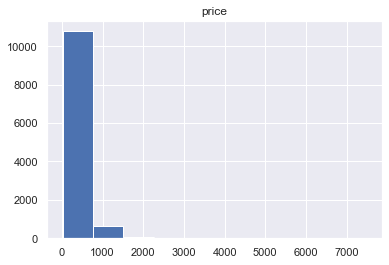

In [5]:
# Comparing price histogram with log(price) histogram
y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000210E707FB08>]],
      dtype=object)

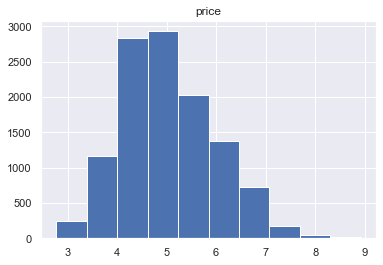

In [6]:
log_y.hist()

In [7]:
# Create dummy variables for categorical columns in the df
features = pd.get_dummies(features, drop_first=True)
features.head()

bathrooms  bedrooms  accommodates  review_scores_rating  number_of_reviews  \
0        2.0       2.0             4                  93.0                 24   
1        1.0       1.0             2                  91.0                  9   
2        1.0       1.0             3                  97.0                529   
3        1.0       1.0             2                  98.0                257   
4        1.0       1.0             2                  99.0                112   

   extra_people  security_deposit  cleaning_fee  property_type_Bungalow  \
0          30.0             500.0         100.0                       0   
1          35.0             500.0          75.0                       0   
2          45.0             100.0           0.0                       0   
3           0.0               0.0           0.0                       0   
4          25.0               0.0          50.0                       0   

   property_type_Condominium  ...  property_type_Serviced apartment  \
0                          0  ...                                 0   
1                          0  ...                                 0   
2                          0  ...                                 0   
3                          0  ...                                 0   
4                          0  ...                                 0   

   property_type_Townhouse  room_type_Hotel room  room_type_Private room  \
0                        0                     0                       0   
1                        0                     0                       1   
2                        0                     0                       0   
3                        0                     0                       1   
4                        0                     0                       0   

   room_type_Shared room  host_is_superhost_t  region_East  region_North  \
0                      0                    1            1             0   
1                      0                    1            1             0   
2                      0                    1            1             0   
3                      0                    1            0             1   
4                      0                    1            0             0   

   region_South  region_West  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             1            0  

[5 rows x 25 columns]

In [8]:
# Using PCA for dimensionality-reduction
from sklearn.decomposition import PCA

# Set up PCA and the X vector for diminsionality reduction
pca = PCA(n_components=1)
df_X = features[[
    'bathrooms',
    'bedrooms',
    'accommodates',
    'extra_people',
    'security_deposit',
    'cleaning_fee',
    'review_scores_rating',
    'number_of_reviews',
]]

# Apply PCA to the dataset X vector
transformed_X = pca.fit_transform(df_X)

# Look at the percentage of variance explained by the different components
print(pca.explained_variance_ratio_)

[0.95625084]


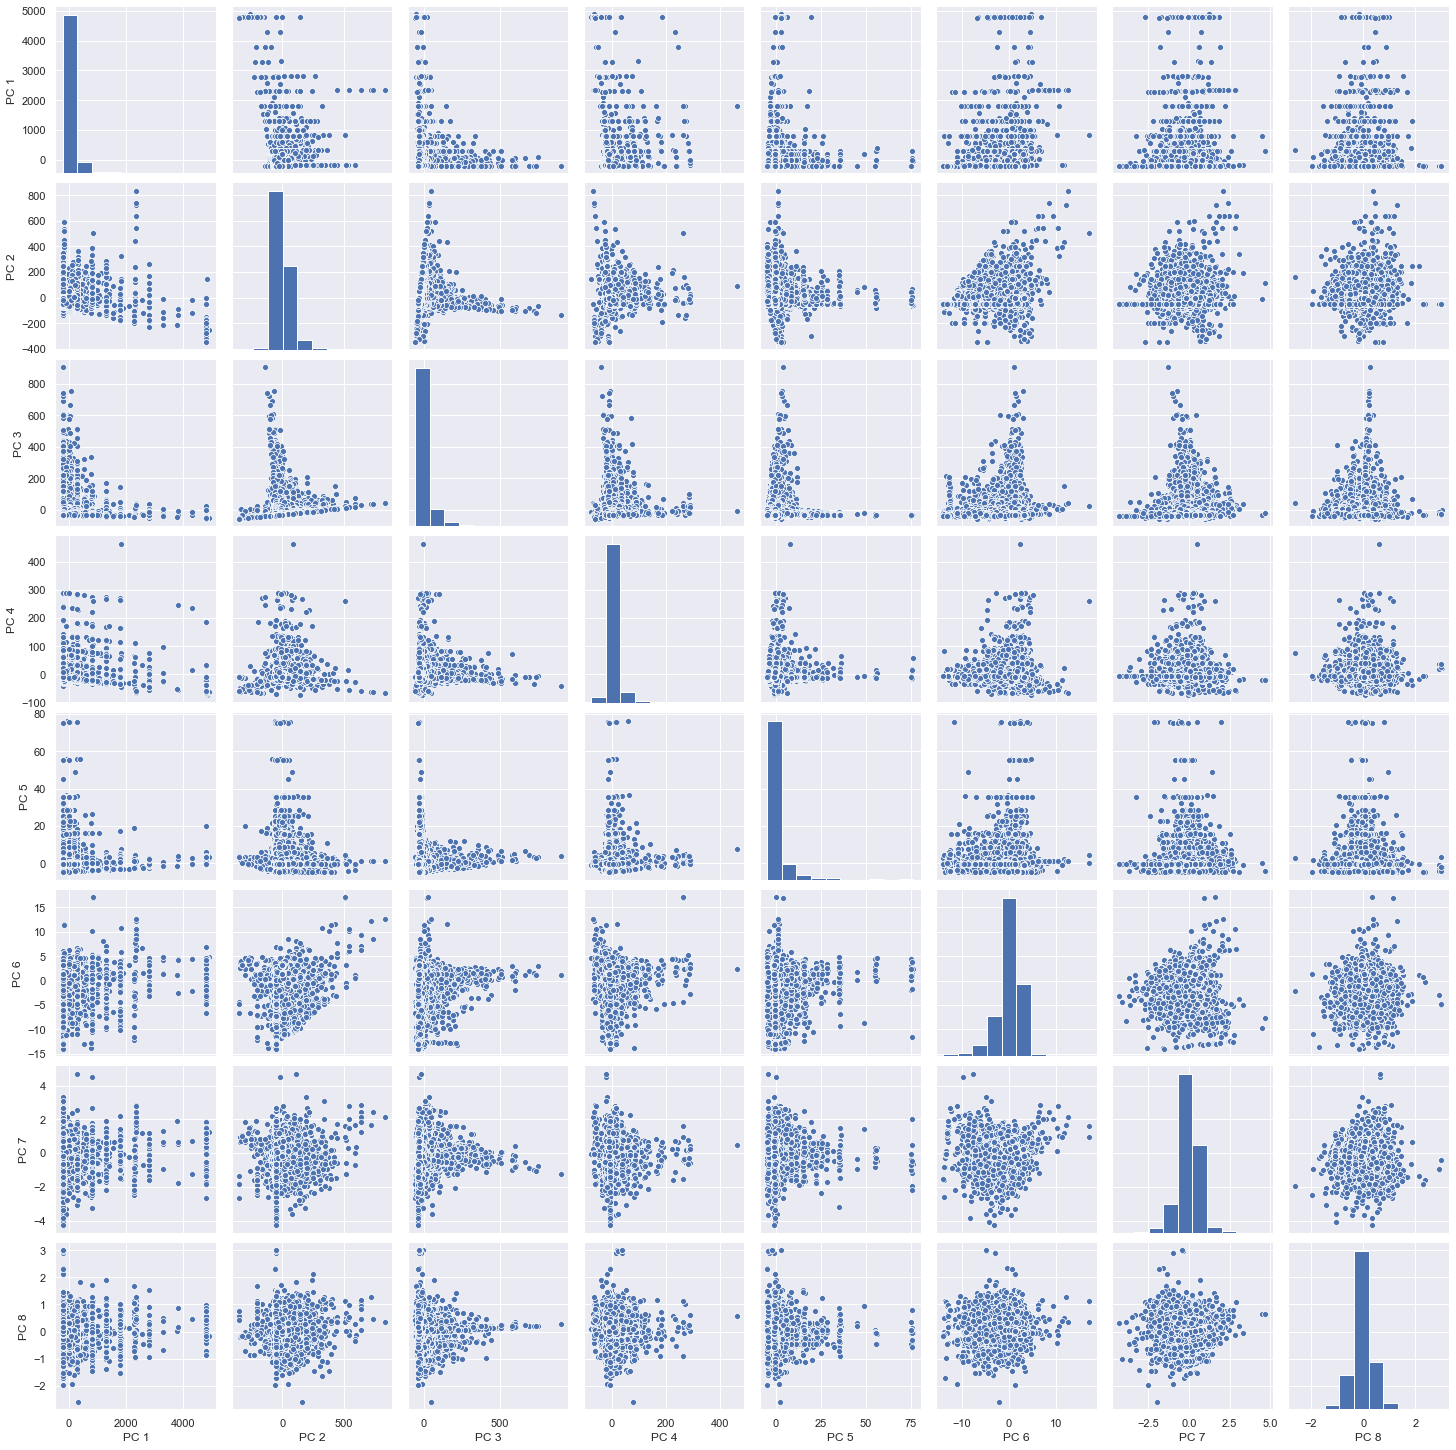

In [9]:
# Create the scaler
scaler = StandardScaler()
ansur_std = scaler.fit_transform(df_X)

# Create the PCA instance and fit and transform the data with pca
pca = PCA()
pc = pca.fit_transform(df_X)
pc_df = pd.DataFrame(pc, columns=['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6', 'PC 7', 'PC 8'])

# Create a pairplot of the principal component dataframe
sns.pairplot(pc_df)
plt.show()

In [10]:
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=2))])
                 
                 
#2. Fit the pipeline to the poke_df dataset and extract the component vectors.

# Fit it to the dataset and extract the component vectors
pipe.fit(df_X)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(df_X.columns, vectors[0]))))
print('PC 2 effects = ' + str(dict(zip(df_X.columns, vectors[1]))))

PC 1 effects = {'bathrooms': 0.49, 'bedrooms': 0.51, 'accommodates': 0.48, 'extra_people': 0.13, 'security_deposit': 0.26, 'cleaning_fee': 0.43, 'review_scores_rating': 0.03, 'number_of_reviews': -0.04}
PC 2 effects = {'bathrooms': -0.11, 'bedrooms': -0.11, 'accommodates': -0.14, 'extra_people': 0.57, 'security_deposit': 0.35, 'cleaning_fee': 0.02, 'review_scores_rating': 0.52, 'number_of_reviews': 0.5}


In [11]:
pipe.steps[1][1].components_.round(2)

array([[ 0.49,  0.51,  0.48,  0.13,  0.26,  0.43,  0.03, -0.04],
       [-0.11, -0.11, -0.14,  0.57,  0.35,  0.02,  0.52,  0.5 ]])

In [12]:
# Pipe a scaler to PCA selecting 80% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.8))])
                 
                 
#2. Fit the pipe to the data.
# Fit the pipe to the data
pipe.fit(df_X)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))



#3. Increase the proportion of variance to keep to 90%.

# Let PCA select 90% of the variance
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=0.9))])

# Fit the pipe to the data
pipe.fit(df_X)

print('{} components selected'.format(len(pipe.steps[1][1].components_)))

5 components selected
6 components selected


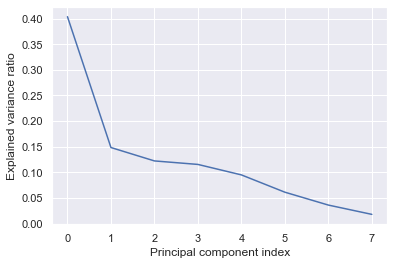

In [13]:
# Pipeline a scaler and PCA selecting 10 components
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=8))])
                 
                 
#2. Fit the pipe to the data.

# Fit the pipe to the data
pipe.fit(df_X)


#3. Plot the explained variance ratio.

# Plot the explained variance ratio
plt.plot(pipe.steps[1][1].explained_variance_ratio_)

plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

In [14]:
# Build the pipeline
pipe = Pipeline([('scaler', StandardScaler()),
        		 ('reducer', PCA(n_components=1))])
                 
                 
#2. Fit the pipeline to the poke_df dataset and extract the component vectors.

# Fit it to the dataset and extract the component vectors
pipe.fit(df_X)
vectors = pipe.steps[1][1].components_.round(2)

# Print feature effects
print('PC 1 effects = ' + str(dict(zip(df_X.columns, vectors[0]))))

PC 1 effects = {'bathrooms': 0.49, 'bedrooms': 0.51, 'accommodates': 0.48, 'extra_people': 0.13, 'security_deposit': 0.26, 'cleaning_fee': 0.43, 'review_scores_rating': 0.03, 'number_of_reviews': -0.04}


In [15]:
# Scale the quantitative features
#scaler = MinMaxScaler()
scaler = StandardScaler()
numerical = [
    'bathrooms',
    'bedrooms',
    'accommodates',
    'extra_people',
    'security_deposit',
    'cleaning_fee',
    'review_scores_rating',
    'number_of_reviews',
]
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [16]:
features_scaled.head()

bathrooms  bedrooms  accommodates  review_scores_rating  number_of_reviews  \
0   0.639164  0.177227     -0.200363             -0.467089          -0.124247   
1  -0.671426 -0.744210     -0.857345             -0.781881          -0.359117   
2  -0.671426 -0.744210     -0.528854              0.162496           7.783033   
3  -0.671426 -0.744210     -0.857345              0.319892           3.524062   
4  -0.671426 -0.744210     -0.857345              0.477289           1.253655   

   extra_people  security_deposit  cleaning_fee  property_type_Bungalow  \
0      0.654481          0.631853      0.403795                       0   
1      0.845062          0.631853      0.081874                       0   
2      1.226224         -0.222533     -0.883888                       0   
3     -0.489006         -0.436129     -0.883888                       0   
4      0.463900         -0.436129     -0.240047                       0   

   property_type_Condominium  ...  property_type_Serviced apartment  \
0                          0  ...                                 0   
1                          0  ...                                 0   
2                          0  ...                                 0   
3                          0  ...                                 0   
4                          0  ...                                 0   

   property_type_Townhouse  room_type_Hotel room  room_type_Private room  \
0                        0                     0                       0   
1                        0                     0                       1   
2                        0                     0                       0   
3                        0                     0                       1   
4                        0                     0                       0   

   room_type_Shared room  host_is_superhost_t  region_East  region_North  \
0                      0                    1            1             0   
1                      0                    1            1             0   
2                      0                    1            1             0   
3                      0                    1            0             1   
4                      0                    1            0             0   

   region_South  region_West  
0             0            0  
1             0            0  
2             0            0  
3             0            0  
4             1            0  

[5 rows x 25 columns]

In [17]:
#features_scaled.to_csv('data/listings_scaled.csv')

### Modeling:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, 
                                                    log_y, 
                                                    test_size = .30, 
                                                    random_state = 42)
                                                    #stratify=log_y)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Test set has {} samples.".format(X_test.shape[0]))

Training set has 8075 samples.
Test set has 3462 samples.


In [19]:
y_test.describe()

price
count  3462.000000
mean      5.040253
std       0.934655
min       2.772589
25%       4.394449
50%       4.897840
75%       5.616771
max       8.803875

In [20]:
y_train.describe()

price
count  8075.000000
mean      5.045965
std       0.940766
min       2.772589
25%       4.382027
50%       4.934474
75%       5.669881
max       8.922658

In [21]:
models = [SVR(kernel='linear'),
          DecisionTreeRegressor(max_depth= 7, min_samples_leaf= 10),
          LinearRegression(),
          KNeighborsRegressor(n_neighbors=7),
          RandomForestRegressor(n_estimators=500, random_state=42)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df)

                       R2 Score
SVR                    0.498112
DecisionTreeRegressor  0.569220
LinearRegression       0.518625
KNeighborsRegressor    0.583925
RandomForestRegressor  0.644146


                       R2 Score
RandomForestRegressor  0.644146
KNeighborsRegressor    0.583925
DecisionTreeRegressor  0.569220
LinearRegression       0.518625
SVR                    0.498112


Text(0.5, 1.0, 'Comparison of Regression Models')

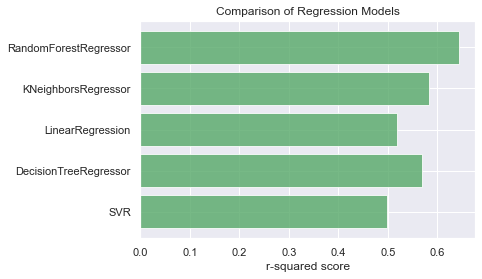

In [22]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df.sort_values('R2 Score', ascending=False))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [23]:
# # Import TPOTRegressor and roc_auc_score
# from tpot import TPOTRegressor
# from sklearn.metrics import r2_score

# # Instantiate TPOTRegressor
# tpot = TPOTRegressor(
#     generations=5,
#     population_size=20,
#     verbosity=2,
#     scoring='r2',
#     random_state=42,
#     disable_update_check=True,
#     config_dict='TPOT light'
# )
# tpot.fit(X_train, y_train)

# # AUC score for tpot model
# tpot_score = r2_score(y_test, tpot.predict(X_test))
# print(f'\nAUC score: {tpot_score:.4f}')

# # Print best pipeline steps
# print('\nBest pipeline steps:', end='\n')
# for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
#     # Print idx and transform
#     print(f'{idx}. {transform}')

In [24]:
# Training Decision Tree Regressor Model
modelDTR = DecisionTreeRegressor()

modelDTR.fit(X_train, y_train)

DecisionTreeRegressor()

In [25]:
X_test

bathrooms  bedrooms  accommodates  review_scores_rating  \
5187   -0.671426 -0.744210     -0.200363             -0.152296   
6260   -0.671426 -0.744210     -0.857345              0.319892   
2069   -0.671426  0.177227      0.456619              0.000760   
7259    1.294459  1.098664      0.456619              0.634685   
4995   -0.671426 -0.744210     -0.857345              0.477289   
...          ...       ...           ...                   ...   
8844    3.915638  3.862973      2.427565              0.000760   
10447   0.639164  2.020100      3.741529              0.162496   
3229   -0.671426 -0.744210     -0.857345             -0.309693   
4513   -0.671426 -0.744210     -0.857345              0.162496   
9585    1.294459  1.098664      1.770583              0.634685   

       number_of_reviews  extra_people  security_deposit  cleaning_fee  \
5187            2.866427     -0.489006         -0.436129     -0.175663   
6260           -0.296485      0.082738         -0.436129     -0.561968   
2069           -0.500039     -0.489006         -0.436129     -0.883888   
7259           -0.390433     -0.489006         -0.436129      0.403795   
4995            0.470756     -0.489006         -0.115734     -0.561968   
...                  ...           ...               ...           ...   
8844           -0.500039     -0.489006          4.903784     -0.883888   
10447          -0.390433     -0.107843         -0.436129      0.403795   
3229            0.392466     -0.489006          0.204660     -0.240047   
4513           -0.171221     -0.184076          0.204660     -0.433199   
9585           -0.453065     -0.489006         -0.436129      0.661331   

       property_type_Bungalow  property_type_Condominium  ...  \
5187                        0                          0  ...   
6260                        0                          1  ...   
2069                        0                          0  ...   
7259                        0                          0  ...   
4995                        0                          0  ...   
...                       ...                        ...  ...   
8844                        0                          0  ...   
10447                       0                          0  ...   
3229                        0                          1  ...   
4513                        0                          0  ...   
9585                        0                          0  ...   

       property_type_Serviced apartment  property_type_Townhouse  \
5187                                  0                        0   
6260                                  0                        0   
2069                                  0                        0   
7259                                  0                        0   
4995                                  0                        0   
...                                 ...                      ...   
8844                                  0                        0   
10447                                 0                        0   
3229                                  0                        0   
4513                                  0                        1   
9585                                  0                        0   

       room_type_Hotel room  room_type_Private room  room_type_Shared room  \
5187                      0                       0                      0   
6260                      0                       1                      0   
2069                      0                       0                      0   
7259                      0                       0                      0   
4995                      0                       0                      0   
...                     ...                     ...                    ...   
8844                      0                       0                      0   
10447                     0                       0                      0   
3229                     

In [26]:
y_test

price
5187   4.595120
6260   4.248495
2069   5.991465
7259   5.703782
4995   4.174387
...         ...
8844   8.671115
10447  5.834811
3229   3.931826
4513   3.806662
9585   5.521461

[3462 rows x 1 columns]

In [27]:
modelDTR.score(X_test, y_test)

0.35562651567516224

In [28]:
# Accuracy score for Decision Tree
y_pred = modelDTR.predict(X_test)
cross_val_score(modelDTR, features_scaled, y, cv=10)
print('Decision Tree Regressor accuracy: {:.2f}'.format(r2_score(y_test, y_pred)))

Decision Tree Regressor accuracy: 0.36


#### Decision Tree Regressor:
##### Hyperparameter Tuning:

In [29]:
# Using GridSearchCV on DecisionTreeRegressor
#create a dictionary of all values we want to test
param_grid = {"max_depth": np.arange(1, 21),
              "max_features": np.arange(1, 9),
              "min_samples_leaf": [20, 40, 100],
              "min_samples_split": [10, 20, 40],
              "max_leaf_nodes": [5, 20, 100],
              #"criterion": ["mse", "mae"]
             }
#use gridsearch to test all values
dtr_cv = GridSearchCV(modelDTR, param_grid, cv=5)
#fit model to data
dtr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7, 8]),
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [30]:
print(dtr_cv.best_params_)
print(cross_val_score(modelDTR, features_scaled, y, cv=10))

{'max_depth': 14, 'max_features': 7, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 20}
[ 0.25331545 -0.19209289 -0.08840213  0.03909699  0.17083741  0.24870994
 -0.45036293 -0.08613312 -0.34487195 -0.92136815]


##### dtr_cv.best_params_:
{'max_depth': 10, 'max_features': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}

In [31]:
modelDTR = DecisionTreeRegressor(max_depth = 10, max_features = 8, max_leaf_nodes = 100,
                                 min_samples_leaf= 20, min_samples_split = 10)
modelDTR.fit(X_train, y_train)
y_test_preds = modelDTR.predict(X_test)
print(y_test_preds)
r2_score(y_test, y_test_preds)

[4.81930388 4.06104972 5.61143618 ... 4.54176116 4.2788231  5.77158302]


0.5647403429698965

In [32]:
lr = LinearRegression()
# Pass data to the LR model
lr.fit(X_train,y_train)
y_test_preds = lr.predict(X_test)
r2_score(y_test, y_test_preds)

0.5186250678767224

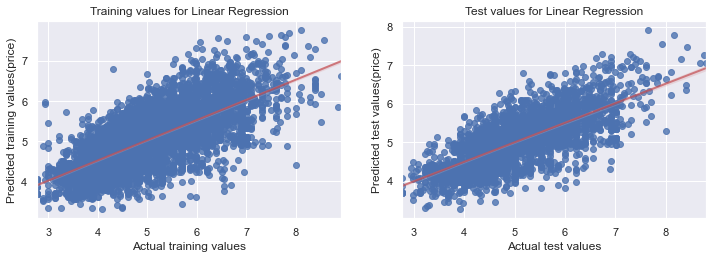

In [33]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
sns.regplot(y_train, lr.predict(X_train), line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual training values')
plt.ylabel('Predicted training values(price)')
plt.title('Training values for Linear Regression')
plt.subplot(2,2,2)
sns.regplot(y_test, lr.predict(X_test), line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual test values')
plt.ylabel('Predicted test values(price)')
plt.title('Test values for Linear Regression')
plt.show()

In [34]:
knn = KNeighborsRegressor()
# Create 3 folds
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
# Define our hyperparameters
params = [{'n_neighbors': [2,3,4,5,6], 'weights': ['uniform','distance']}]

# Search for best hyperparameters
grid = GridSearchCV(estimator=knn, param_grid=params, cv=kfold, scoring='r2')
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [2, 3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             scoring='r2')

In [35]:
# Get the results
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.5161820528900858
KNeighborsRegressor(n_neighbors=6)
{'n_neighbors': 6, 'weights': 'uniform'}


In [36]:
knn = KNeighborsRegressor(n_neighbors= 6, weights= 'uniform')
knn.fit(X_train, y_train)
predictions = knn.predict(X_test)
knn_mse = mean_squared_error(predictions, y_test)
knn_mse

0.3689530660247285

#### Random Forest Regressor:
##### Hyperparameter Tuning:

In [37]:
modelRFR = RandomForestRegressor(random_state=42)

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]
# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
param_grid = { 
    #'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': [True]
}

In [39]:
#%%time
#CV_RFR = GridSearchCV(estimator=modelRFR, param_grid=param_grid, cv= 5)
#CV_RFR.fit(X_train, np.ravel(y_train))

In [40]:
#CV_RFR.best_params_

##### CV_RFR.best_params_:
{'bootstrap': True,
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [41]:
modelRFR=RandomForestRegressor(max_features='auto', n_estimators= 1000, max_depth=15, min_samples_split=10, min_samples_leaf=2, bootstrap=True, random_state=42)

#### XGB Regressor:
##### Hyperparameter Tuning:

In [42]:
xgb1 = XGBRegressor()
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True)

In [43]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  45 out of  45 | elapsed:  2.2min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=False,
                                    verbosity=None),
             n

In [44]:
xgb_grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

##### xgb.best_params_:
{'colsample_bytree': 0.7,
 'learning_rate': 0.03,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:linear',
 'silent': 1,
 'subsample': 0.7}

In [45]:
print("Best Params XGB MSE:", round(mean_squared_error(y_test, xgb_grid.predict(X_test)),4))
print("Best Params XGB r2:", round(r2_score(y_test, xgb_grid.predict(X_test)),4))

Best Params XGB MSE: 0.2871
Best Params XGB r2: 0.6713


In [46]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(
    colsample_bytree= 0.7,
    learning_rate= 0.03,
    max_depth= 5,
    min_child_weight= 4,
    n_estimators= 500,
    nthread= 4,
    objective= 'reg:linear',
    silent= 1,
    subsample= 0.7
)
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
test_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))

Time taken to run: 0.1 minutes

Training MSE: 0.2449
Test MSE: 0.2883

Training r2: 0.7232
Test r2: 0.6699


In [47]:
# models with hyperparameter tuning

models = [SVR(kernel='linear'),
          modelDTR,
          LinearRegression(),
          knn,
          modelRFR,
          xgb_reg]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]
    results[name] = r2_score(y_test, y_test_preds)
    
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df)

                       R2 Score
SVR                    0.498112
DecisionTreeRegressor  0.569003
LinearRegression       0.518625
KNeighborsRegressor    0.577532
RandomForestRegressor  0.661397
XGBRegressor           0.669908


                       R2 Score
XGBRegressor           0.669908
RandomForestRegressor  0.661397
KNeighborsRegressor    0.577532
DecisionTreeRegressor  0.569003
LinearRegression       0.518625
SVR                    0.498112


Text(0.5, 1.0, 'Comparison of Regression Models')

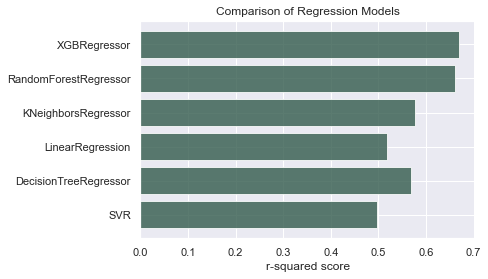

In [48]:
results_df = pd.DataFrame(results.values(), index=results.keys(), columns=['R2 Score'])
print(results_df.sort_values('R2 Score', ascending=False))

fig, ax = plt.subplots()

ind = range(len(results))
ax.barh(ind, list(results.values()), align='center', 
        color = '#325A4C', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(results.keys())
ax.set_xlabel('r-squared score')
ax.tick_params(left=False, top=False, right=False) 
ax.set_title('Comparison of Regression Models')
#fig.savefig('images/compare_models.png', bbox_inches = 'tight')

In [49]:
# Plotly to visualize the feature importances
import plotly.graph_objs as go
from plotly.offline import iplot, plot, init_notebook_mode
import plotly.express as px

#### Random Forest Feature Importance

In [50]:
feature_importance = modelRFR.feature_importances_
feature_importance

array([0.06929483, 0.34956355, 0.11200976, 0.02596496, 0.10437873,
       0.03266169, 0.03794786, 0.10199438, 0.00131916, 0.00571388,
       0.00065334, 0.00142845, 0.00966714, 0.00198617, 0.0071949 ,
       0.00305418, 0.00202258, 0.00082585, 0.06687347, 0.01979087,
       0.01019873, 0.00878759, 0.01082874, 0.01219661, 0.00364258])

In [51]:
features_scaled.columns

Index(['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating',
       'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee',
       'property_type_Bungalow', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_t', 'region_East',
       'region_North', 'region_South', 'region_West'],
      dtype='object')

In [52]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='Random Forest Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')

#### XGB Feature Importance

In [53]:
feature_importance = xgb_reg.feature_importances_
feature_importance

array([0.05953407, 0.22932252, 0.12456026, 0.01206095, 0.02926352,
       0.0192447 , 0.01602725, 0.03980677, 0.00970171, 0.01496468,
       0.01046988, 0.01054134, 0.02040692, 0.02164799, 0.02203531,
       0.02277329, 0.01100016, 0.0104775 , 0.17236863, 0.06750487,
       0.0169692 , 0.01039809, 0.02676586, 0.01153779, 0.01061676],
      dtype=float32)

In [54]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='XGB Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')

In [55]:
import statsmodels.api as sm

X_train_ = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_.astype(float))
res = ols_model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     323.4
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:30:32   Log-Likelihood:                -8157.0
No. Observations:                8075   AIC:                         1.637e+04
Df Residuals:                    8049   BIC:                         1.655e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

The OLS results summary provides a brief description on how each feature measures with its p-value and other test scores, which is very useful in selecting our features for the model. We can select our features using p-value set at 0.05 as a standard measure so that we can avoid collinearity issues.

In [56]:
# Training the data again by removing some features which may not be useful in detecting the price in our model.

X_train_new = X_train_.drop(columns=["review_scores_rating", "property_type_Guesthouse", "property_type_Serviced apartment",
                                    "property_type_Bungalow", "property_type_House"], axis=1)

ols_model_new = sm.OLS(y_train, X_train_new.astype(float))
res_new = ols_model_new.fit()

print(res_new.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.500
Method:                 Least Squares   F-statistic:                     404.2
Date:                Sun, 02 Aug 2020   Prob (F-statistic):               0.00
Time:                        12:30:32   Log-Likelihood:                -8158.1
No. Observations:                8075   AIC:                         1.636e+04
Df Residuals:                    8054   BIC:                         1.651e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [57]:
data_dmatrix = xgb.DMatrix(data=features_scaled,label=log_y)
data_dmatrix

In [58]:
xg_reg = XGBRegressor(
    colsample_bytree= 0.7,
    learning_rate= 0.03,
    max_depth= 5,
    min_child_weight= 4,
    n_estimators= 500,
    nthread= 4,
    objective= 'reg:linear',
    silent= 1,
    subsample= 0.7,
    random_state= 42
)

In [59]:
xg_reg.fit(X_train,y_train)
y_pred_test = xg_reg.predict(X_test)
y_pred_train = xg_reg.predict(X_train)

In [60]:
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
print("Test RMSE: %f" % (test_rmse))
print("Train RMSE: %f" % (train_rmse))
#print("Test RMSLE:", round(mean_squared_log_error(y_test, y_pred_test),4))
#print("Train RMSLE:", round(mean_squared_log_error(y_train, y_pred_train),4))
print("Test R2:", round(r2_score(y_test, y_pred_test),4))
print("Train R2:", round(r2_score(y_train, y_pred_train),4))

Test RMSE: 0.537808
Train RMSE: 0.493900
Test R2: 0.6688
Train R2: 0.7243


In [61]:
y_pred_test = pd.DataFrame(y_pred_test)
y_pred_test.index = y_test.index
y_pred_test

0
5187   4.621227
6260   3.984305
2069   5.764413
7259   5.975497
4995   4.426118
...         ...
8844   7.898561
10447  5.997143
3229   4.511352
4513   4.342955
9585   5.858433

[3462 rows x 1 columns]

In [62]:
y_test.rename(columns={"price":'Actual Price'}, inplace=True)
y_test

Actual Price
5187       4.595120
6260       4.248495
2069       5.991465
7259       5.703782
4995       4.174387
...             ...
8844       8.671115
10447      5.834811
3229       3.931826
4513       3.806662
9585       5.521461

[3462 rows x 1 columns]

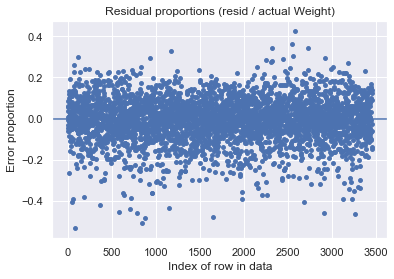

In [63]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = y_test.values
resid = y_actual - y_pred_test
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight)')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

#### The residual proportions indicate that our predictions are mostly within 20-25% of the correct value.

In [64]:
test_preds = pd.concat([y_test, y_pred_test], axis=1)
test_preds.columns = ['Actual Price', 'Predicted Price']
#test_preds['Actual Price'] = np.exp(test_preds['Actual Price'])
#test_preds['Predicted Price'] = np.exp(test_preds['Predicted Price'])
test_preds

Actual Price  Predicted Price
5187       4.595120         4.621227
6260       4.248495         3.984305
2069       5.991465         5.764413
7259       5.703782         5.975497
4995       4.174387         4.426118
...             ...              ...
8844       8.671115         7.898561
10447      5.834811         5.997143
3229       3.931826         4.511352
4513       3.806662         4.342955
9585       5.521461         5.858433

[3462 rows x 2 columns]

In [65]:
test_preds['Percent Correct'] = round(test_preds['Predicted Price'] / test_preds['Actual Price'], 2)
test_preds['Residual'] = round(test_preds['Actual Price'] - test_preds['Predicted Price'], 2)
test_preds['Residual Proportions'] = round(test_preds['Residual'] / test_preds['Actual Price'], 2)

In [66]:
test_preds

Actual Price  Predicted Price  Percent Correct  Residual  \
5187       4.595120         4.621227             1.01     -0.03   
6260       4.248495         3.984305             0.94      0.26   
2069       5.991465         5.764413             0.96      0.23   
7259       5.703782         5.975497             1.05     -0.27   
4995       4.174387         4.426118             1.06     -0.25   
...             ...              ...              ...       ...   
8844       8.671115         7.898561             0.91      0.77   
10447      5.834811         5.997143             1.03     -0.16   
3229       3.931826         4.511352             1.15     -0.58   
4513       3.806662         4.342955             1.14     -0.54   
9585       5.521461         5.858433             1.06     -0.34   

       Residual Proportions  
5187                  -0.01  
6260                   0.06  
2069                   0.04  
7259                  -0.05  
4995                  -0.06  
...                     ...  
8844                   0.09  
10447                 -0.03  
3229                  -0.15  
4513                  -0.14  
9585                  -0.06  

[3462 rows x 5 columns]

In [67]:
print(test_preds['Residual Proportions'].min())
print(test_preds['Residual Proportions'].max())

-0.54
0.43


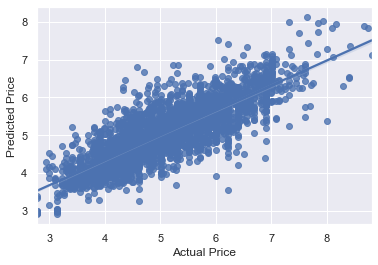

In [68]:
sns.regplot(x=test_preds['Actual Price'], y=test_preds['Predicted Price'], data=test_preds, ci=95)

In [69]:
y_pred_train = pd.DataFrame(y_pred_train)
y_pred_train.index = y_train.index
y_train.rename(columns={"price":'Actual Price'}, inplace=True)

In [70]:
train_preds = pd.concat([y_train, y_pred_train], axis=1)
train_preds.columns = ['Actual Price', 'Predicted Price']
#train_preds['Actual Price'] = np.exp(train_preds['Actual Price'])
#train_preds['Predicted Price'] = np.exp(train_preds['Predicted Price'])
train_preds['Percent Correct'] = round(train_preds['Predicted Price'] / train_preds['Actual Price'], 2)
train_preds['Residual'] = round(train_preds['Actual Price'] - train_preds['Predicted Price'], 2)
train_preds['Residual Proportions'] = round(train_preds['Residual'] / train_preds['Actual Price'], 2)
train_preds

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
3319       4.941642         4.198684             0.85      0.74   
9526       2.995732         4.393638             1.47     -1.40   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
...             ...              ...              ...       ...   
11284      4.605170         4.487941             0.97      0.12   
5191       5.402677         5.463145             1.01     -0.06   
5390       6.802395         6.171529             0.91      0.63   
860        4.510860         4.286910             0.95      0.22   
7270       4.941642         5.032198             1.02     -0.09   

       Residual Proportions  
9311                   0.04  
3319                   0.15  
9526                  -0.47  
1739                   0.05  
230                   -0.01  
...                     ...  
11284                  0.03  
5191                  -0.01  
5390                   0.09  
860                    0.05  
7270                  -0.02  

[8075 rows x 5 columns]

In [71]:
print(train_preds['Residual Proportions'].min())
print(train_preds['Residual Proportions'].max())

-0.78
0.37


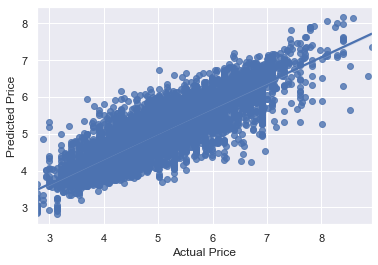

In [72]:
sns.regplot(x=train_preds['Actual Price'], y=train_preds['Predicted Price'], data=train_preds, ci=95)

In [73]:
preds_df = pd.concat([train_preds, test_preds])
preds_df

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
3319       4.941642         4.198684             0.85      0.74   
9526       2.995732         4.393638             1.47     -1.40   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
...             ...              ...              ...       ...   
8844       8.671115         7.898561             0.91      0.77   
10447      5.834811         5.997143             1.03     -0.16   
3229       3.931826         4.511352             1.15     -0.58   
4513       3.806662         4.342955             1.14     -0.54   
9585       5.521461         5.858433             1.06     -0.34   

       Residual Proportions  
9311                   0.04  
3319                   0.15  
9526                  -0.47  
1739                   0.05  
230                   -0.01  
...                     ...  
8844                   0.09  
10447                 -0.03  
3229                  -0.15  
4513                  -0.14  
9585                  -0.06  

[11537 rows x 5 columns]

In [74]:
# Setting a threshold of .25
threshold = [0.75, 1.25]

In [75]:
threshold_25 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_25

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
3319       4.941642         4.198684             0.85      0.74   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
6162       6.396930         5.918166             0.93      0.48   
...             ...              ...              ...       ...   
8844       8.671115         7.898561             0.91      0.77   
10447      5.834811         5.997143             1.03     -0.16   
3229       3.931826         4.511352             1.15     -0.58   
4513       3.806662         4.342955             1.14     -0.54   
9585       5.521461         5.858433             1.06     -0.34   

       Residual Proportions  
9311                   0.04  
3319                   0.15  
1739                   0.05  
230                   -0.01  
6162                   0.08  
...                     ...  
8844                   0.09  
10447                 -0.03  
3229                  -0.15  
4513                  -0.14  
9585                  -0.06  

[11238 rows x 5 columns]

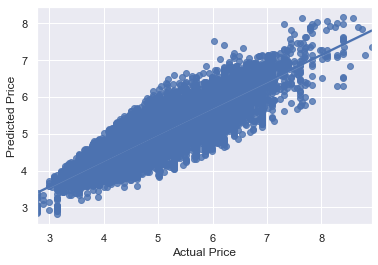

In [76]:
sns.regplot(x=threshold_25['Actual Price'], y=threshold_25['Predicted Price'], data=threshold_25, ci=95)

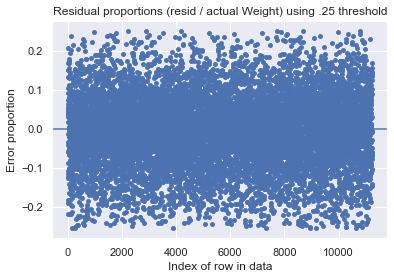

In [77]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_25['Actual Price'].values
resid = y_actual - threshold_25['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .25 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [78]:
# Calculate % of how many rental prices our model predicted in the .25 threshold range
print('Using .25 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_25),
                                                                         len(preds_df), len(threshold_25)/len(preds_df)))

Using .25 threshold, we get 11,238 rental prices out of 11,537 which means 97.4% predicted are in range


In [79]:
# Setting a threshold of .15
threshold = [0.85, 1.15]

threshold_15 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_15

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
3319       4.941642         4.198684             0.85      0.74   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
6162       6.396930         5.918166             0.93      0.48   
...             ...              ...              ...       ...   
8844       8.671115         7.898561             0.91      0.77   
10447      5.834811         5.997143             1.03     -0.16   
3229       3.931826         4.511352             1.15     -0.58   
4513       3.806662         4.342955             1.14     -0.54   
9585       5.521461         5.858433             1.06     -0.34   

       Residual Proportions  
9311                   0.04  
3319                   0.15  
1739                   0.05  
230                   -0.01  
6162                   0.08  
...                     ...  
8844                   0.09  
10447                 -0.03  
3229                  -0.15  
4513                  -0.14  
9585                  -0.06  

[10142 rows x 5 columns]

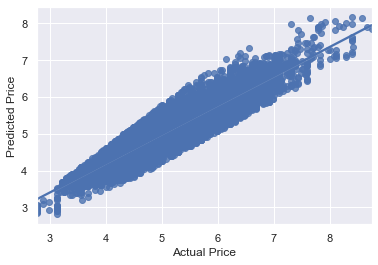

In [80]:
sns.regplot(x=threshold_15['Actual Price'], y=threshold_15['Predicted Price'], data=threshold_15, ci=95)

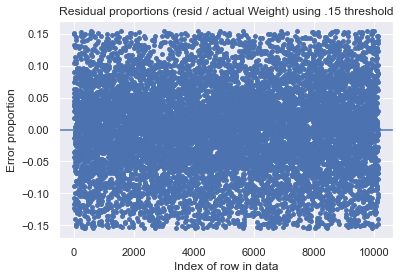

In [81]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_15['Actual Price'].values
resid = y_actual - threshold_15['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .15 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [82]:
# Calculate % of how many rental prices our model predicted in the .15 threshold range
print('Using .15 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_15),
                                                                         len(preds_df), len(threshold_15)/len(preds_df)))

Using .15 threshold, we get 10,142 rental prices out of 11,537 which means 87.9% predicted are in range


In [83]:
# Setting a threshold of .1
threshold = [0.90, 1.10]

threshold_10 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_10

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
6162       6.396930         5.918166             0.93      0.48   
9060       4.744932         5.012117             1.06     -0.27   
...             ...              ...              ...       ...   
3464       4.442651         4.477633             1.01     -0.03   
8977       4.744932         5.067639             1.07     -0.32   
8844       8.671115         7.898561             0.91      0.77   
10447      5.834811         5.997143             1.03     -0.16   
9585       5.521461         5.858433             1.06     -0.34   

       Residual Proportions  
9311                   0.04  
1739                   0.05  
230                   -0.01  
6162                   0.08  
9060                  -0.06  
...                     ...  
3464                  -0.01  
8977                  -0.07  
8844                   0.09  
10447                 -0.03  
9585                  -0.06  

[8562 rows x 5 columns]

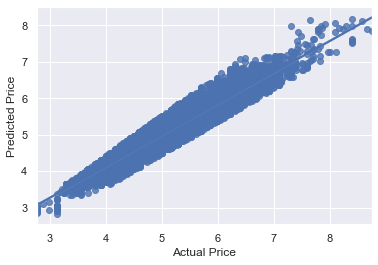

In [84]:
sns.regplot(x=threshold_10['Actual Price'], y=threshold_10['Predicted Price'], data=threshold_10, ci=95)

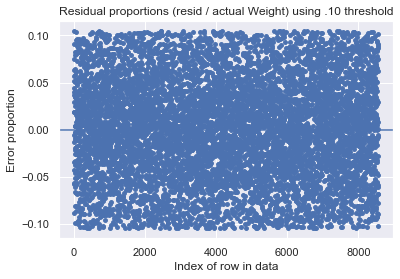

In [85]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_10['Actual Price'].values
resid = y_actual - threshold_10['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .10 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [86]:
# Calculate % of how many rental prices our model predicted in the .10 threshold range
print('Using .10 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_10),
                                                                         len(preds_df), len(threshold_10)/len(preds_df)))

Using .10 threshold, we get 8,562 rental prices out of 11,537 which means 74.2% predicted are in range


In [87]:
# Setting a threshold of .05
threshold = [0.95, 1.05]

threshold_5 = preds_df[(preds_df['Percent Correct'] >= threshold[0]) & (preds_df['Percent Correct'] <= threshold[1])]
threshold_5

Actual Price  Predicted Price  Percent Correct  Residual  \
9311       5.517453         5.298644             0.96      0.22   
1739       5.521461         5.275040             0.96      0.25   
230        4.595120         4.655211             1.01     -0.06   
4639       4.744932         4.657672             0.98      0.09   
5936       4.007333         4.177892             1.04     -0.17   
...             ...              ...              ...       ...   
1400       5.192957         5.441289             1.05     -0.25   
7844       4.727388         4.753220             1.01     -0.03   
10005      5.068904         4.920140             0.97      0.15   
3464       4.442651         4.477633             1.01     -0.03   
10447      5.834811         5.997143             1.03     -0.16   

       Residual Proportions  
9311                   0.04  
1739                   0.05  
230                   -0.01  
4639                   0.02  
5936                  -0.04  
...                     ...  
1400                  -0.05  
7844                  -0.01  
10005                  0.03  
3464                  -0.01  
10447                 -0.03  

[5592 rows x 5 columns]

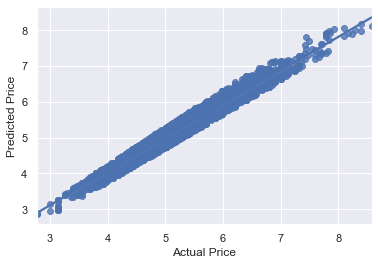

In [88]:
sns.regplot(x=threshold_5['Actual Price'], y=threshold_5['Predicted Price'], data=threshold_5, ci=95)

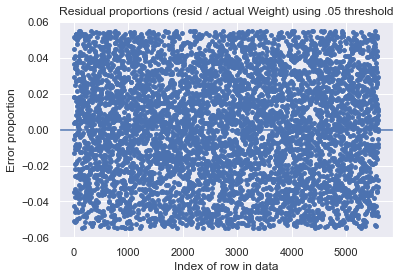

In [89]:
# Let's see how close or far off our predictions are comparing to the actual values
y_actual = threshold_5['Actual Price'].values
resid = y_actual - threshold_5['Predicted Price']
resid_prop = resid / y_actual
plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
plt.axhline(0)
plt.title('Residual proportions (resid / actual Weight) using .05 threshold')
plt.xlabel('Index of row in data')
plt.ylabel('Error proportion');

In [90]:
# Calculate % of how many rental prices our model predicted in the .05 threshold range
print('Using .05 threshold, we get {:,d} rental prices out of {:,d} which means {:.1%} predicted are in range'.format(len(threshold_5),
                                                                         len(preds_df), len(threshold_5)/len(preds_df)))

Using .05 threshold, we get 5,592 rental prices out of 11,537 which means 48.5% predicted are in range


In [91]:
# sample_df = preds_df.sample(frac=.9, random_state=42)
# sample_df[sample_df['Percent Correct']<0]

In [92]:
# threshold = [0.75, 1.25]

# sample_df[(sample_df['Percent Correct'] > threshold[0]) & (sample_df['Percent Correct'] < threshold[1])]

In [93]:
# sns.regplot(x=sample_df['Actual Price'], y=sample_df['Predicted Price'], data=sample_df, ci=95)

In [94]:
# # Let's see how close or far off our predictions are comparing to the actual values
# y_actual = sample_df['Actual Price'].values
# resid = y_actual - sample_df['Predicted Price']
# resid_prop = resid / y_actual
# plt.scatter(np.arange(len(resid_prop)), resid_prop, s=15)
# plt.axhline(0)
# plt.title('Residual proportions (resid / actual Weight)')
# plt.xlabel('Index of row in data')
# plt.ylabel('Error proportion');

In [95]:
# def simple_resample(n): 
#     return(np.random.randint(low = 0, high = n, size = n))

In [96]:
# def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
#     n = len(boot_pop)
#     resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
#     return resample_estimates

In [97]:
# def bedrooms_coeff(data_array):
#     X = data_array[:, 1:]
#     y = data_array[:, 0]
    
#     linear_model = LinearRegression()
#     model = linear_model.fit(X, y)
#     theta_bedrooms = model.coef_[1]

#     return theta_bedrooms

# data_array = df_cleaned.loc[:, ["price", "bedrooms", "accommodates"]].values

# theta_hat_sampling = bootstrap(data_array, bedrooms_coeff)

In [98]:
# plt.figure(figsize = (7, 5))
# plt.hist(theta_hat_sampling, bins = 30)
# plt.xlabel("$\\tilde{\\theta}_{bathrooms}$ Values")
# plt.ylabel("Proportion per Unit")
# plt.title("Bootstrap Sampling Distribution of $\\tilde{\\theta}_{bathrooms}$ (Nonparametric)");
# plt.show()

In [99]:
# left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
# right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

# left_confidence_interval_endpoint, right_confidence_interval_endpoint

In [100]:
X_test[numerical]

bathrooms  bedrooms  accommodates  extra_people  security_deposit  \
5187   -0.671426 -0.744210     -0.200363     -0.489006         -0.436129   
6260   -0.671426 -0.744210     -0.857345      0.082738         -0.436129   
2069   -0.671426  0.177227      0.456619     -0.489006         -0.436129   
7259    1.294459  1.098664      0.456619     -0.489006         -0.436129   
4995   -0.671426 -0.744210     -0.857345     -0.489006         -0.115734   
...          ...       ...           ...           ...               ...   
8844    3.915638  3.862973      2.427565     -0.489006          4.903784   
10447   0.639164  2.020100      3.741529     -0.107843         -0.436129   
3229   -0.671426 -0.744210     -0.857345     -0.489006          0.204660   
4513   -0.671426 -0.744210     -0.857345     -0.184076          0.204660   
9585    1.294459  1.098664      1.770583     -0.489006         -0.436129   

       cleaning_fee  review_scores_rating  number_of_reviews  
5187      -0.175663             -0.152296           2.866427  
6260      -0.561968              0.319892          -0.296485  
2069      -0.883888              0.000760          -0.500039  
7259       0.403795              0.634685          -0.390433  
4995      -0.561968              0.477289           0.470756  
...             ...                   ...                ...  
8844      -0.883888              0.000760          -0.500039  
10447      0.403795              0.162496          -0.390433  
3229      -0.240047             -0.309693           0.392466  
4513      -0.433199              0.162496          -0.171221  
9585       0.661331              0.634685          -0.453065  

[3462 rows x 8 columns]

In [101]:
invers_numerical = scaler.inverse_transform(X_test[numerical])

In [102]:
invers_numerical[0]

array([  1.,   1.,   4.,   0.,   0.,  55.,  95., 215.])

In [103]:
original_df = features[numerical]
original_df.iloc[5187]

bathrooms                 1.0
bedrooms                  1.0
accommodates              4.0
extra_people              0.0
security_deposit          0.0
cleaning_fee             55.0
review_scores_rating     95.0
number_of_reviews       215.0
Name: 5187, dtype: float64

In [104]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=42)

In [105]:
cv_results.head()

train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         4.194765        0.003070        4.194762       0.006351
1         3.790393        0.003019        3.790512       0.006544
2         3.428817        0.003098        3.428375       0.006740
3         3.105694        0.004735        3.105087       0.008365
4         2.813154        0.005723        2.812419       0.009897

In [106]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.593129
Name: test-rmse-mean, dtype: float64


In [107]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

In [108]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'

# xgb.plot_tree(xg_reg,num_trees=0)
# plt.rcParams['figure.figsize'] = [50, 20]
# plt.show()

In [109]:
# models with hyperparameter tuning

models = [SVR(kernel='linear'),
          modelDTR,
          LinearRegression(),
          knn,
          modelRFR,
          xgb_reg]

MSE, MAE, R2, RMSE, Adj_R2 = [],[],[],[],[]

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train.values.ravel())
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    MSE.append(mean_squared_error(y_test,y_test_preds))
    MAE.append(mean_absolute_error(y_test,y_test_preds))
    R2.append(r2_score(y_test,y_test_preds))
    RMSE.append(math.sqrt(mean_squared_error(y_test,y_test_preds)))
    Adj_R2.append(1 - (1-r2_score(y_test,y_test_preds)) * (len(X_test)-1)/(len(X_test)-len(features_scaled.columns)-1))
    
pd.DataFrame([MSE, MAE, R2, RMSE, Adj_R2],index = ['MSE','MAE','R2','RMSE','Adjusted R2'],
             columns = ['SVR', 'Decision Tree Reg', 'Linear Reg', 'K Nearest Neighbor',
                        'Random Forest Reg', 'Gradient Boosting Regressor']).style.background_gradient()

In [110]:
feature_importance = xgb_reg.feature_importances_
feature_importance

array([0.05953407, 0.22932252, 0.12456026, 0.01206095, 0.02926352,
       0.0192447 , 0.01602725, 0.03980677, 0.00970171, 0.01496468,
       0.01046988, 0.01054134, 0.02040692, 0.02164799, 0.02203531,
       0.02277329, 0.01100016, 0.0104775 , 0.17236863, 0.06750487,
       0.0169692 , 0.01039809, 0.02676586, 0.01153779, 0.01061676],
      dtype=float32)

In [111]:
features_scaled.columns

Index(['bathrooms', 'bedrooms', 'accommodates', 'review_scores_rating',
       'number_of_reviews', 'extra_people', 'security_deposit', 'cleaning_fee',
       'property_type_Bungalow', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_House', 'property_type_Loft', 'property_type_Other',
       'property_type_Serviced apartment', 'property_type_Townhouse',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'host_is_superhost_t', 'region_East',
       'region_North', 'region_South', 'region_West'],
      dtype='object')

In [112]:
importances = pd.DataFrame({'feature': features_scaled.columns, 'importance': feature_importance}).sort_values('importance', ascending=False).reset_index(drop=True)

trace = go.Bar(x=importances.head(40).feature, y=importances.head(10).importance)

layout = go.Layout(title='XGB Feature Importances',
                  yaxis=dict(title='Relative Importance'))

fig = go.Figure([trace], layout)
fig.update_xaxes(tickangle=90)
iplot(fig, filename='feature_importance.html')